<a href="https://colab.research.google.com/github/Tensorflow-Ranger/Calling-Wikipedia-API/blob/master/Speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import ffmpeg

In [50]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1AdJoE9b_lXeoQIo06RZtqMCkJ6txN4Kd/view?usp=sharing'
id = link.split("/")[5]

link2 = "https://drive.google.com/file/d/1RfqwPj1mGgy7wctZ7atBAIpg3FITMFf-/view?usp=sharing"
id2 = link.split("/")[5]
downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('piano_B4_resampled - Copy (3).wavTimeStrech')  

In [41]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return X, y


def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    global X_test
    # load dataset
    X, y = load_data(data_path)

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    return X_train, y_train, X_validation, y_validation, X_test, y_test


In [43]:
DATA_PATH = "data.json"
SAVED_MODEL_PATH = "model.h5"
EPOCHS = 100
BATCH_SIZE = 2
PATIENCE = 5
LEARNING_RATE = 0.0001
loss= "sparse_categorical_crossentropy"
learning_rate=0.0001

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [44]:
optimiser = tf.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimiser,loss=loss,metrics=["accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 44, 64)            19968     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


In [45]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history

In [46]:
def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()


In [48]:
def predict(model,X,):
  X = X[np.newaxis,...]
  prediction = model.predict(X)
  predicted_index = np.argmax(prediction, axis=1)
  print(predicted_index)

Training sets loaded!
(1984, 44, 13) (1984,) (496, 44, 13) (496,) (620, 44, 13) (620,)
Epoch 1/100
992/992 [==============================] - 8s 8ms/step - loss: 0.0696 - accuracy: 0.9839 - val_loss: 0.0619 - val_accuracy: 0.9819
Epoch 2/100
992/992 [==============================] - 8s 8ms/step - loss: 0.0415 - accuracy: 0.9914 - val_loss: 0.0472 - val_accuracy: 0.9819
Epoch 3/100
992/992 [==============================] - 8s 8ms/step - loss: 0.0306 - accuracy: 0.9934 - val_loss: 0.0390 - val_accuracy: 0.9859
Epoch 4/100
992/992 [==============================] - 8s 8ms/step - loss: 0.0286 - accuracy: 0.9924 - val_loss: 0.0255 - val_accuracy: 0.9899
Epoch 5/100
992/992 [==============================] - 8s 8ms/step - loss: 0.0186 - accuracy: 0.9960 - val_loss: 0.0214 - val_accuracy: 0.9940
Epoch 6/100
992/992 [==============================] - 8s 8ms/step - loss: 0.0127 - accuracy: 0.9980 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 7/100
992/992 [==============================] - 

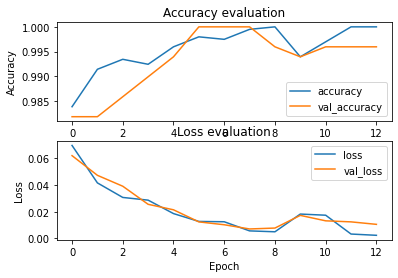

20/20 [==============================] - 0s 5ms/step - loss: 0.0090 - accuracy: 0.9968

Test loss: 0.008956434205174446, test accuracy: 99.67741966247559
[6]


In [49]:
X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)
print(X_train.shape,y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

input_shape = (X_train.shape[1], X_train.shape[2])

history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

plot_history(history)

test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

X = X_test[100]
predict(model,X)


model.save(SAVED_MODEL_PATH)

In [68]:
from google.colab import files
files.download('model.h5')

In [62]:
def create_silence():
  path='piano_B4_resampled - Copy (3).wavTimeStrech' 
  maxv = np.iinfo(np.int16).max
  sounds = [x[len(DB):] for x in glob.glob(path+ '*.wav')]
  for elem in sounds:
    sound=elem.split('\\')[1]
    print(sound)
    for j,i in enumerate(np.arange(0.0, 59.0, 0.3)):
        y, fs=librosa.load(DB+elem, sr=None, offset=i, duration=1.0, mono=False)
        librosa.output.write_wav(DB+'silence/'+str(j)+sound, y=(y*maxv).astype(np.int16), sr=fs, norm=False)

In [64]:
!dir

adc.json   model.h5					   sample_data
data.json  piano_B4_resampled\ -\ Copy\ (3).wavTimeStrech


In [67]:
signal, sample_rate = librosa.load('piano_B4_resampled - Copy (3).wavTimeStrech')

NoBackendError: ignored